In [1]:
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import tqdm

In [2]:
protein_sequences_labelled = pd.read_csv("filtered_labelled_protein_sequences.tsv", sep = "\t")

In [3]:
max_seq_len = max(protein_sequences_labelled['concatenated_sequence'].apply(len))

In [4]:
protein_seq_by_type = protein_sequences_labelled.groupby('classification')['concatenated_sequence'].apply(list).to_dict()

In [5]:
all_sequences = ''.join(protein_sequences_labelled['concatenated_sequence'].values)
all_characters = list(set(all_sequences)) + ["PAD"]
character_index = {char: all_characters.index(char) for char in all_characters}
n_characters = len(all_characters)

all_protein_classifications = protein_sequences_labelled['classification'].unique().tolist()
n_classifications = len(all_protein_classifications)

In [6]:
def polypeptide_to_indices(polypeptide):
    return torch.tensor([character_index[AA] for AA in polypeptide], dtype=torch.long)

In [7]:
class ProteinDataset(Dataset):
    def __init__(self, protein_sequences_labelled, transform=None, target_transform=None):
        self.protein_sequences_labelled = protein_sequences_labelled
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.protein_sequences_labelled)
    
    def __getitem__(self, idx):
        row = self.protein_sequences_labelled.iloc[idx]
        protein_sequence = row['concatenated_sequence']
        label = row['classification']
       
        if self.transform:
            sequence_tensor = self.transform(protein_sequence)
        else:
            sequence_tensor = polypeptide_to_indices(protein_sequence)

        if self.target_transform:
            label = self.target_transform(label)
        else:
            label = torch.tensor([all_protein_classifications.index(label)], dtype=torch.long)

        return sequence_tensor, label

In [8]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    sequences, labels = zip(*batch)

    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=character_index["PAD"])
    
    stacked_labels = torch.cat(labels) 

    return padded_sequences, stacked_labels

In [9]:
train_data, temp_data = train_test_split(
    protein_sequences_labelled, 
    test_size=0.2,  
    stratify=protein_sequences_labelled['classification']  
)

test_data, val_data = train_test_split(
    temp_data, 
    test_size=0.5,  
    stratify=temp_data['classification']
)

train_dataset = ProteinDataset(train_data)
test_dataset = ProteinDataset(test_data)
val_dataset = ProteinDataset(val_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Training dataset size: 80943
Validation dataset size: 10118
Test dataset size: 10118


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import math
from torch import Tensor

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
 
        seq_len = x.size(1)
        x = x + self.pe[:seq_len, :].unsqueeze(0).to(x.device)
        return self.dropout(x)
    
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, hidden_dim, num_layers, num_classes, max_len=max_seq_len):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.positional_encoding = PositionalEncoding(d_model=embedding_dim, max_len=max_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=hidden_dim, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        # Embedding
        x = self.embedding(x)  
        x = self.positional_encoding(x)  
        x = x.permute(1, 0, 2) 
        x = self.transformer_encoder(x)  
        x = x.permute(1, 0, 2) )
        x = x.mean(dim=1) 
        x = self.fc(x)  
        return x


In [11]:
vocab_size = n_characters 
embedding_dim = 64               
num_heads = 8                     
hidden_dim = 96                  
num_layers = 3                    
num_classes = n_classifications   

model = TransformerClassifier(vocab_size=vocab_size,
                              embedding_dim=embedding_dim,
                              num_heads=num_heads,
                              hidden_dim=hidden_dim,
                              num_layers=num_layers,
                              num_classes=num_classes).to(device)

In [12]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def train(dataloader, model, criterion, optimizer, num_epochs):
    model.train()  
    all_losses = []  

    for epoch in range(num_epochs):
        total_loss = 0.0
        epoch_losses = []  
        with tqdm(total=len(dataloader), desc="Training Progress", unit='batch') as pbar:
            for line_tensor, category_tensor in dataloader:
                optimizer.zero_grad()

                line_tensor = line_tensor.to(device).contiguous()
                category_tensor = category_tensor.to(device)
                output = model(line_tensor)
                
                loss = criterion(output, category_tensor)
                epoch_losses.append(loss.item())  # Save batch loss for this epoch
                
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

                pbar.set_postfix(loss=loss.item())
                pbar.update(1) 

        all_losses.append(sum(epoch_losses) / len(epoch_losses))
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {all_losses[-1]}")

    return all_losses  

In [13]:
num_epochs = 15  # Set the number of epochs
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = train(train_loader, model, criterion=criterion, optimizer=optimizer, num_epochs=num_epochs)

Training Progress: 100%|██████████| 2530/2530 [02:53<00:00, 14.61batch/s, loss=2.78]


Epoch 1/15, Loss: 2.8469753059002723


Training Progress: 100%|██████████| 2530/2530 [02:55<00:00, 14.38batch/s, loss=2.63]


Epoch 2/15, Loss: 2.76780083895672


Training Progress: 100%|██████████| 2530/2530 [02:55<00:00, 14.44batch/s, loss=3.1] 


Epoch 3/15, Loss: 2.698498802411226


Training Progress: 100%|██████████| 2530/2530 [02:55<00:00, 14.41batch/s, loss=2.38]


Epoch 4/15, Loss: 2.6465215254206904


Training Progress: 100%|██████████| 2530/2530 [02:54<00:00, 14.51batch/s, loss=2.45]


Epoch 5/15, Loss: 2.604460087124067


Training Progress: 100%|██████████| 2530/2530 [02:53<00:00, 14.62batch/s, loss=2.05]


Epoch 6/15, Loss: 2.58297774584397


Training Progress: 100%|██████████| 2530/2530 [02:53<00:00, 14.62batch/s, loss=2.65]


Epoch 7/15, Loss: 2.5601741921760346


Training Progress: 100%|██████████| 2530/2530 [02:52<00:00, 14.66batch/s, loss=2.91]


Epoch 8/15, Loss: 2.545103681417322


Training Progress: 100%|██████████| 2530/2530 [02:52<00:00, 14.69batch/s, loss=2.68]


Epoch 9/15, Loss: 2.529665408916624


Training Progress: 100%|██████████| 2530/2530 [02:53<00:00, 14.59batch/s, loss=1.95]


Epoch 10/15, Loss: 2.5140920156546733


Training Progress: 100%|██████████| 2530/2530 [02:53<00:00, 14.62batch/s, loss=1.89]


Epoch 11/15, Loss: 2.4984070054627217


Training Progress: 100%|██████████| 2530/2530 [02:53<00:00, 14.55batch/s, loss=2.64]


Epoch 12/15, Loss: 2.4861693315826385


Training Progress: 100%|██████████| 2530/2530 [02:54<00:00, 14.50batch/s, loss=2.96]


Epoch 13/15, Loss: 2.471977536904482


Training Progress: 100%|██████████| 2530/2530 [02:54<00:00, 14.53batch/s, loss=2.23]


Epoch 14/15, Loss: 2.461562378180357


Training Progress: 100%|██████████| 2530/2530 [02:54<00:00, 14.48batch/s, loss=2.21]

Epoch 15/15, Loss: 2.448389589409583


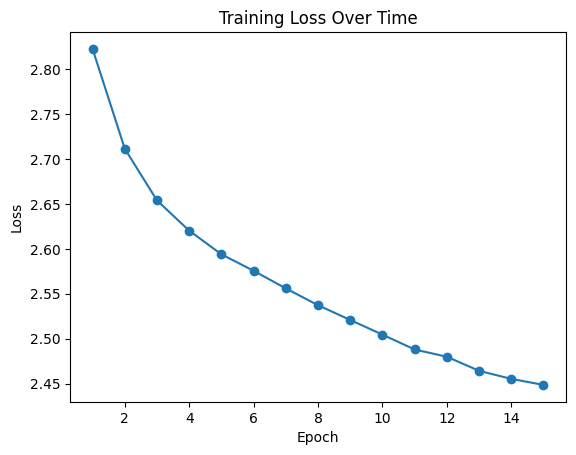

In [46]:
plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

In [47]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def create_confusion_matrix(model, data_loader, device):
    # Set the model to evaluation mode
    model.eval()
    
    true_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for sequences, labels in data_loader:
            sequences = sequences.to(device).contiguous()
            labels = labels.to(device)
            
            outputs = model(sequences)
            
            _, predicted = torch.max(outputs, 1)
            
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
    
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    
    cm = confusion_matrix(true_labels, predicted_labels)
    
    return cm, true_labels, predicted_labels

confusion_mat, true_labels, predicted_labels = create_confusion_matrix(model, test_loader, device)

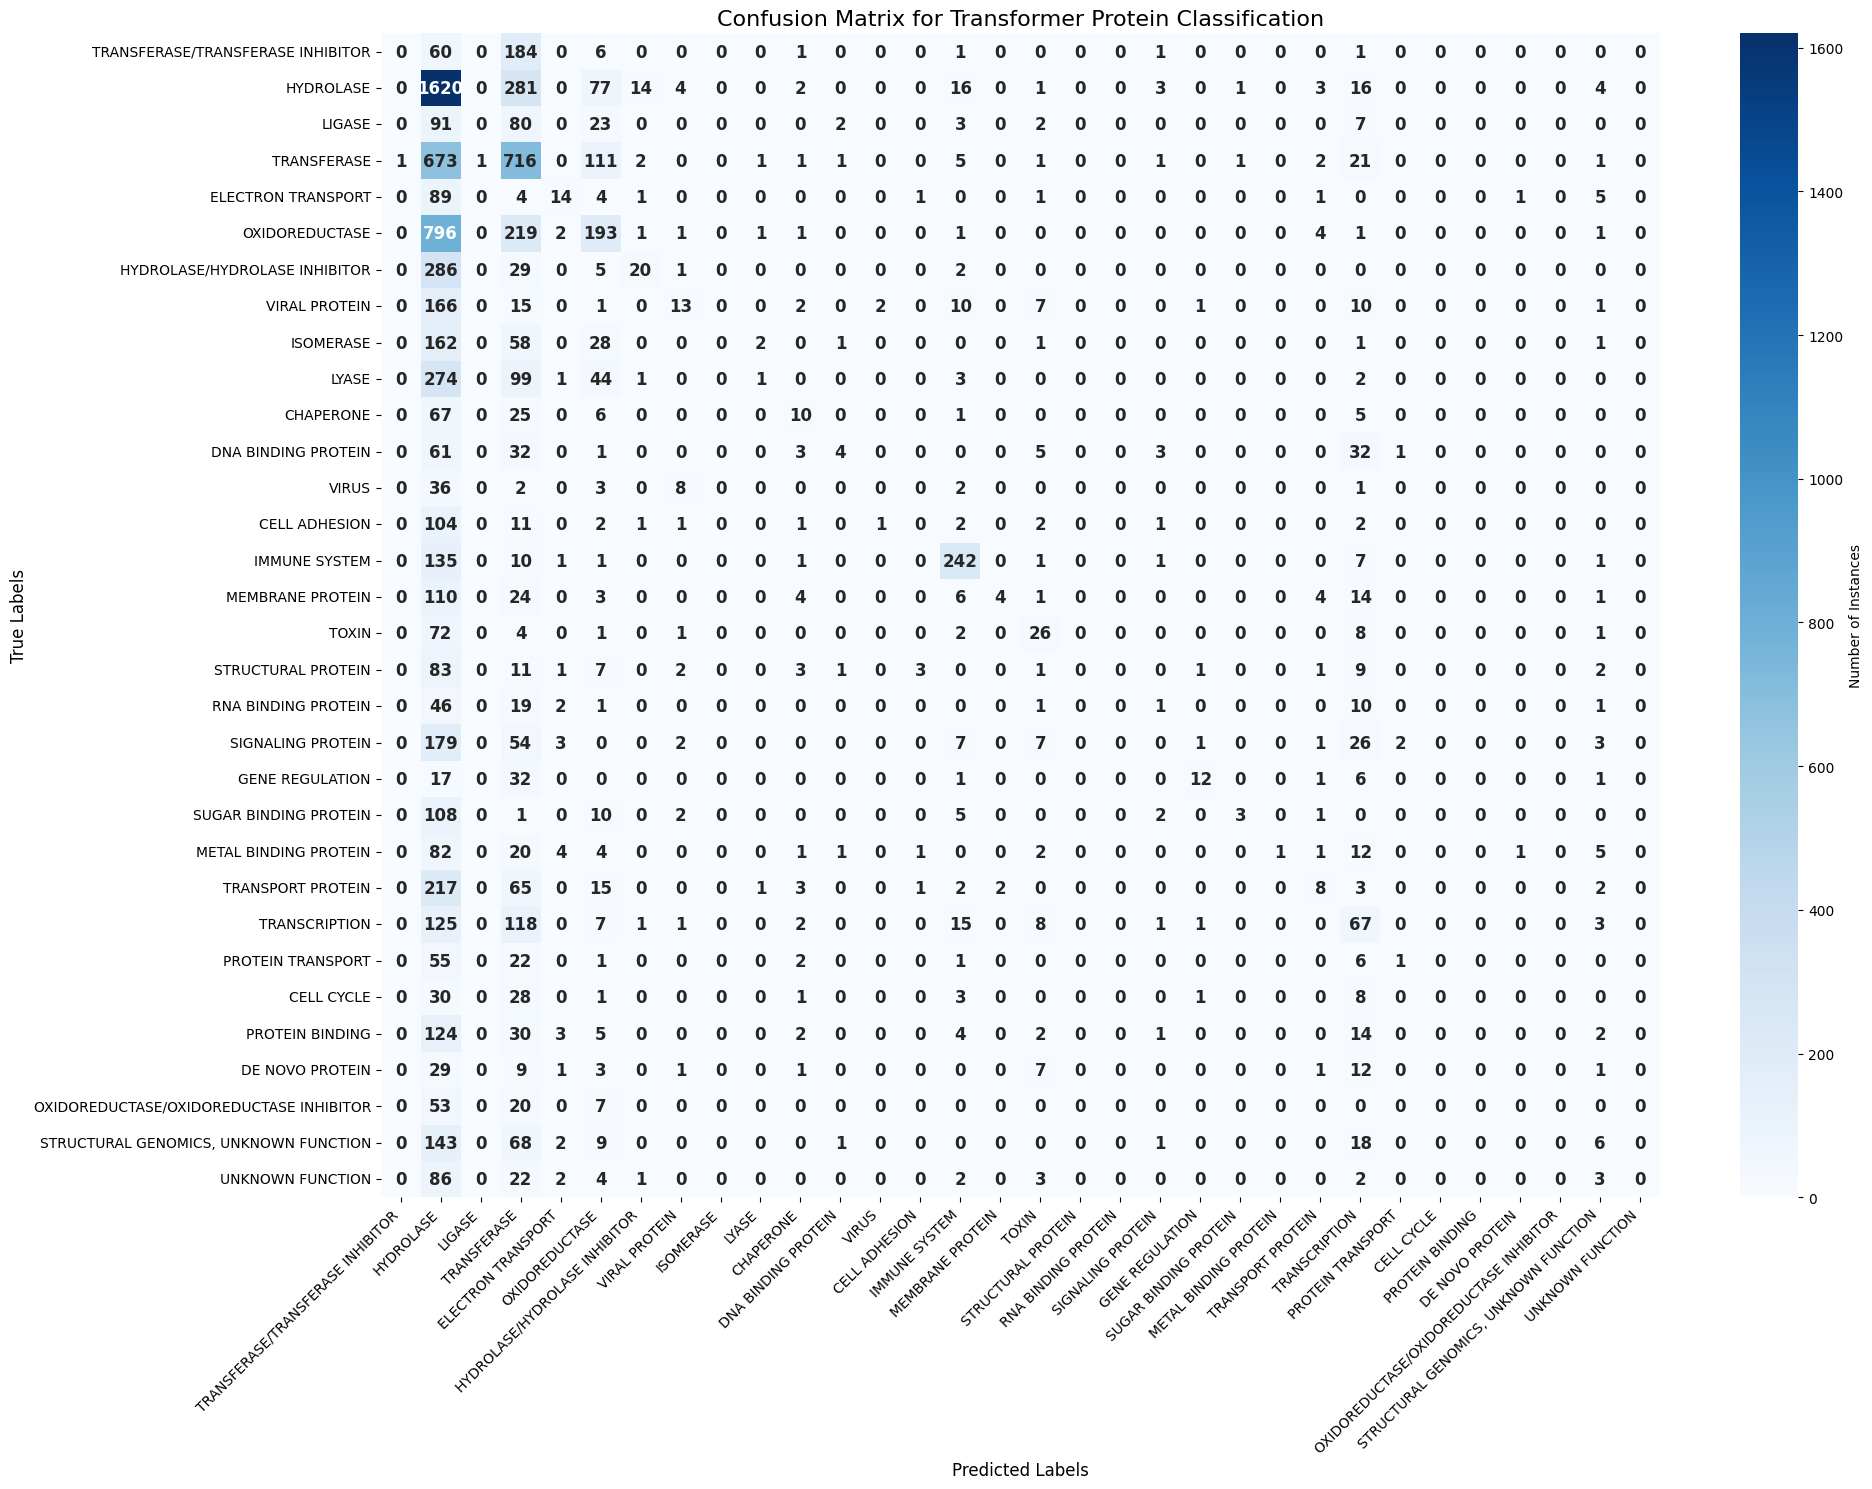

In [48]:
plt.figure(figsize=(20, 15)) 
sns.heatmap(confusion_mat, 
            annot=True,  
            fmt='d',     
            cmap='Blues', 
            xticklabels=all_protein_classifications, 
            yticklabels=all_protein_classifications,
            annot_kws={'size': 12, 'weight':'bold'},  # Larger, bold annotations
            cbar_kws={'label': 'Number of Instances'})

plt.title('Confusion Matrix for Transformer Protein Classification', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [24]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

def calculate_classification_metrics(true_labels, predicted_labels):    
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        true_labels, predicted_labels, average='macro'
    )
    
    return macro_precision, macro_recall, macro_f1

precision, recall, f1 = calculate_classification_metrics(true_labels, predicted_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
precision

0.18414068052239094

In [26]:
recall

0.08937297031416414

In [27]:
f1

0.0839251350925791

In [28]:
from sklearn.metrics import accuracy_score
accuracy_score(true_labels, predicted_labels)

0.2810832180272781

In [31]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np

def evaluate_model(model, dataloader, criterion):
    model.eval()  
    all_labels = []
    all_predictions = []

    with torch.no_grad(): 
        for sequences, labels in dataloader:
            sequences = sequences.to(device).contiguous()
            labels = labels.to(device)

            outputs = model(sequences)
            probabilities = torch.softmax(outputs, dim=1) 

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(probabilities.cpu().numpy())
    
    return np.array(all_labels), np.array(all_predictions)

In [33]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

labels, predictions = evaluate_model(model, val_loader, criterion)
n_classes = predictions.shape[1]
binary_labels = label_binarize(labels, classes=range(n_classes))


fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binary_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC and AUC
fpr["macro"], tpr["macro"], _ = roc_curve(binary_labels.ravel(), predictions.ravel())
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

/tmp/ipykernel_218365/3121112261.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap('viridis')


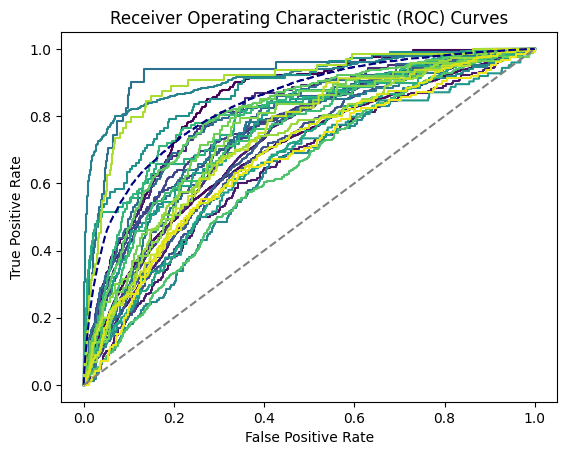

In [34]:
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt

colormap = get_cmap('viridis')
colors = [colormap(i / n_classes) for i in range(n_classes)]  # Dynamically generate colors

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle='--', label=f"Macro-average (AUC = {roc_auc['macro']:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.show()

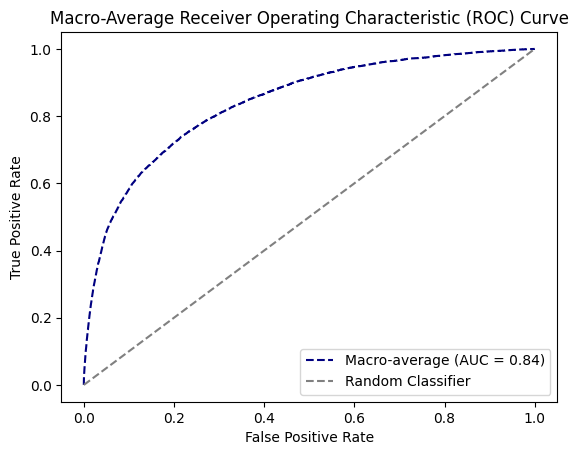

In [35]:
plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle='--', label=f"Macro-average (AUC = {roc_auc['macro']:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-Average Receiver Operating Characteristic (ROC) Curve')

plt.legend(loc="lower right")

plt.show()
